In [1]:
import sys
sys.path.insert(0, "/uscms_data/d3/rverma/codes/CMSSW_11_2_0_pre5/src/hgcal-econd-buffer/hgcalEnv/lib/python3.6/site-packages/")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import matplotlib.patches as mpatches

from matplotlib.collections import PatchCollection
import matplotlib

In [2]:
#list of number of link that are assigned
linkSummary = pd.read_csv('geomInfo/ModuleLinkSummary.csv')

# six cassettes are put together to form one layer. Currently, we look at only 0th cassete of a few layers (5,7,9)
linkSummary = linkSummary[(linkSummary.Cassette==0) & (linkSummary.Layer>=5) & (linkSummary.Layer<=9)]

# The (ModU, modV) is the (U, V) coordinate of a module (=wafer=econ) within a layer
linkSummary.set_index(['Layer','ModU','ModV'],inplace=True)

In [3]:
#load data from csv files.  This is used to extract average data sizes
#daq_Data = pd.concat([pd.read_csv(f'Data/ttbar_copy_new.csv') for i in range(16)])
daq_Data = pd.read_csv('Data/ttbar_eolNoise_DAQ_data_0.csv')
'''
The daq_Data consist of the entries after applying ZS corresponding to different cells 
(a layer has many wafers, a wafer has many cells). The description about the each of columns
(c1): It is the index of df
(c2 = entry): those events which passed the ZS
(c3 = layer): layer number (from 5 to 9)
(c4 = waferu): U coordinate of the wafer
(c5 = waferv): V coordinate of the wafer

(c6 = HDM): high density module: One of the 8-inch wafers/modules with 432 cells 
(compared to the LDM, or low-density module, which has 192 cells)
the type 0 are 120 micron thick and HDM and closest to beam pipe,
type 1 is 200 microns thick LDM modules, and a little further out
type 2 are 300 micron LDM modules, and furthest from beam pipe in eta
If HDM is True then it correspond to type 0 else 1 or 2

(c7 = occ): Occupancy: Each wafer has 3-6 eLink, each eLink has up to 37 channels, 
we’ve applied the zero suppression, so any channel below the threshold is removed, 
so the count is just counting how many cells on a given eLink on a given wafer pass the ZS

(c8 = eRxPacket_Words): It is the size of the packet in terms of number of words (1 word is of 32 bit).
It is calculated as int(Bits/32+1) + 2, where Bits = 16  + 8* (charge_BX1 + toa_BX2)

(c9  = NonEmptyLinks): We have total 6 (12) eLinks for HDM(LDM). 

(c10 = EmptyLinks): The rest eLinks

(c11 = TotalWords): evt_headerWords (=2) + eRxPacket_Words + EmptyLinks + evt_trailerWords (=2)

''' 
daq_Data

,entry,layer,waferu,waferv,HDM,occ,eRxPacket_Words,NonEmptyLinks,EmptyLinks,TotalWords
0,4002,5,11,6,False,1,3,1,5,12
1,4007,5,11,6,False,1,3,1,5,12
2,4009,5,11,6,False,1,3,1,5,12
3,54001,5,11,6,False,1,3,1,5,12
4,54003,5,11,6,False,1,3,1,5,12
5,54005,5,11,6,False,1,3,1,5,12
6,54009,5,11,6,False,1,3,1,5,12
7,4001,5,11,5,False,1,3,1,5,12
8,4003,5,11,5,False,1,3,1,5,12
9,4009,5,11,5,False,1,3,1,5,12


In [4]:
#get list of wedges, and assign x and y positions for drawing maps
wedges = daq_Data.groupby(['layer','waferu','waferv']).any()[['HDM']].reset_index()
wedges['y'] = wedges.waferv
wedges['x'] = 0
#QQQQ: why 2+v-2*u?
wedges.loc[:,'x'] = (2+wedges.y-2*wedges.waferu)
#QQQQ: why rescale y and x?
wedges.y *= 1.5
wedges.x *= -3**.5/2
wedges.set_index(['layer','waferu','waferv'],inplace=True)

In [5]:
#function to look through output logs of condor jobs to extract and accumulate the results across several runs
# if you just ran interactivel, need to just get the info on the overflows, max size, etc into a dataframe.

def getDF(inputDF, LogName=None,Nstart=0,N=100):
    #QQQQ: Why mean?
    fullData = inputDF.groupby(['layer','waferu','waferv']).mean()
    
    #linkSummary has only 153 rows which means the last 10 rows will be assigned Nan. 
    #QQQQ: Why linkSummary has only 153 rows?
    fullData['eTx_assigned'] = linkSummary.ECOND_eTX
    
    #Replace Nan by 1
    fullData.eTx_assigned = fullData.eTx_assigned.fillna(1).astype(int)
    
    #The numpy.ceil() is a mathematical function that returns the ceil of the elements of array. 
    #The ceil of the scalar x is the smallest integer i, such that i >= x
    #QQQQ: why divide by 53.3333? One eTx can process 53.3333 Words of data?
    fullData['eTx_30percent'] = np.ceil((fullData.TotalWords/53.3333)*1.3).astype(int)
    fullData['eTx_Mean'] = np.ceil((fullData.TotalWords/53.3333))
    '''
    Every condor output has information for 6 econs (they have different # eLinks)
    We collect information from ALL condor outputs for ALL econs in a 2D (163,6) array

    overflows: An econ with few number of eLink is overflow for a few thousands times in 
    few million BX which means for few billion BXs (many condor outputs) the overflows should be added

    maxSize: Among all condor outouts, it is the maximum buffer size. Which means it is NOT additive

    L1As issued: How many times an L1A is issued for a given number of BXs. Which means it is additive

    '''
    if not LogName is None:
        data_overflow = []
        data_maxSize = []
        L1As_issued=0
        bHist = []
        #Get the 0th element of the list from 0th condor file
        fileName = f'condor/tmpSub/log/{LogName}_{Nstart}.stdout'
        with open(fileName,'r') as _file:
            # we loop over all lines of the condor output and extract
            for line in _file:
                if 'overflows= ' in line:
                    #overflows= [...]
                    data_overflow.append(eval(line[10:]))
                if 'maxSize= ' in line:
                    #maxSize= [...]
                    data_maxSize.append(eval(line[8:]))
                if 'L1As issued' in line:
                    #749401 L1As issued
                    L1As_issued += int(line.split()[0])
                if 'sizeHist= ' in line:
                    bHist.append(eval(line[9:]))
        #2D array            
        data_overflow=np.array(data_overflow)
        data_maxSize=np.array(data_maxSize)
        buff_Hist = np.array(bHist)

        for i_file in range(Nstart+1,Nstart+N):
            fileName = f'condor/tmpSub/log/{LogName}_{i_file}.stdout'
            bHist = []
            with open(fileName,'r') as _file:
                for line in _file:
                    if 'eTx' in line:
                        #1 eTx
                        i = int(line.split()[0])-1
                    if 'overflows= ' in line:
                        overflow=np.array(eval(line[10:]))
                        overflow[overflow<0] = 99999999
                        data_overflow[i] += overflow
                    if 'maxSize= ' in line:
                        maxSize=np.array(eval(line[8:]))
                        data_maxSize[i] = np.maximum(data_maxSize[i], maxSize)
                    if 'L1As issued' in line:
                        L1As_issued += int(line.split()[0])
                    if 'sizeHist= ' in line:
                        bHist.append(eval(line[9:]))
            buff_Hist += np.array(bHist)
        
        '''
        The idea is to check how many eLinks are needed for a given wafer in order to avoid overflow.
        For example, the wafer closer to beam axis need more eLinks and vice versa. In this way we can
        efficiantly allocate different number of eLinks to different wafers
        '''
        #transpose (163 col, 6 rows) to (6 cols, 163 rows)
        #In every row look at zero (True==0) and non-zero entries
        #Multiply the respective entry by array([1, 2, 3, 4, 5, 6])
        print(data_overflow)
        x = ((data_overflow.transpose()==0)*np.arange(1,7))

        #change all zero entries to 99 (we can choose any large value)
        x[x==0]=99
        
        #for every row, get the minimum value (out of 6 econs, pick the one which has minimum eLink)
        minLinks = x.min(axis=1)
        fullData['min_eTx'] = minLinks
        nLinks = minLinks
        
        #Get the maximum size of the buffer of the corresponding econ with minLinks
        maxSize = []
        for i in range(len(nLinks)):
            maxSize.append(data_maxSize.transpose()[i][nLinks[i]-1])
        fullData['maxSize'] = maxSize    

        nLinks = fullData.eTx_Mean.values
        maxSize = []
        overflows = []
        for i in range(len(nLinks)):
            maxSize.append(data_maxSize.transpose()[i][int(nLinks[i])-1])
            overflows.append(data_overflow.transpose()[i][int(nLinks[i])-1])
        fullData['maxSize_Mean'] = maxSize
        fullData['overflows_Mean'] = overflows

        
        nLinks = fullData.eTx_assigned.values
        maxSize = []
        overflows = []
        for i in range(len(nLinks)):
            maxSize.append(data_maxSize.transpose()[i][nLinks[i]-1])
            overflows.append(data_overflow.transpose()[i][nLinks[i]-1])
        fullData['maxSize_assigned'] = maxSize
        fullData['overflows_assigned'] = overflows
        

        nLinks = fullData.eTx_30percent.values
        maxSize = []
        overflows = []
        for i in range(len(nLinks)):
            maxSize.append(data_maxSize.transpose()[i][nLinks[i]-1])
            overflows.append(data_overflow.transpose()[i][nLinks[i]-1])
        fullData['maxSize_30percent'] = maxSize
        fullData['overflows_30percent'] = overflows
        print("fullData = ", fullData)
        #print("L1As_issued = ", L1As_issued)
        #print("data_overflow = ", data_overflow)
        #print("data_maxSize = ", data_maxSize)
    #return fullData, L1As_issued, data_overflow, data_maxSize, buff_Hist
    #print("buff_Hist", buff_Hist)
    return fullData, L1As_issued, buff_Hist, data_overflow, data_maxSize

In [6]:
#fullData,L1As, buffHist, OF, MS = getDF(daq_Data,LogName='bufferSim__34676729',Nstart=0,N=2)
fullData,L1As, buffHist, OF, MS = getDF(daq_Data,LogName='bufferSim__15174127',Nstart=0,N=100)

[[5578837 4889601 4376590 4977360 4972260 2514756 3227830 3541661 3276676
        0     755 1854852 1854116     325       0       0       0       0
        0       0       0       0       0       0       0       0       0
        0       0       0       0       0       0       0       0       0
        0       0       0       0       0       0       0       0       0
        0       0       0       0       0       0       0       0 5506435
  4827510 4164758 4812696 4821259 2219330 2988140 3266707 2998737       0
        1 1502273 1496455       0       0       0       0       0       0
        0       0       0       0       0       0       0       0       0
        0       0       0       0       0       0       0       0       0
        0       0       0       0       0       0       0       0       0
        0       0       0       0       0       0       0       0       0
  5332697 4638152 3790822 4516462 4532470 1727467 2526199 2869753 2576862
        0       0  961599  991362     

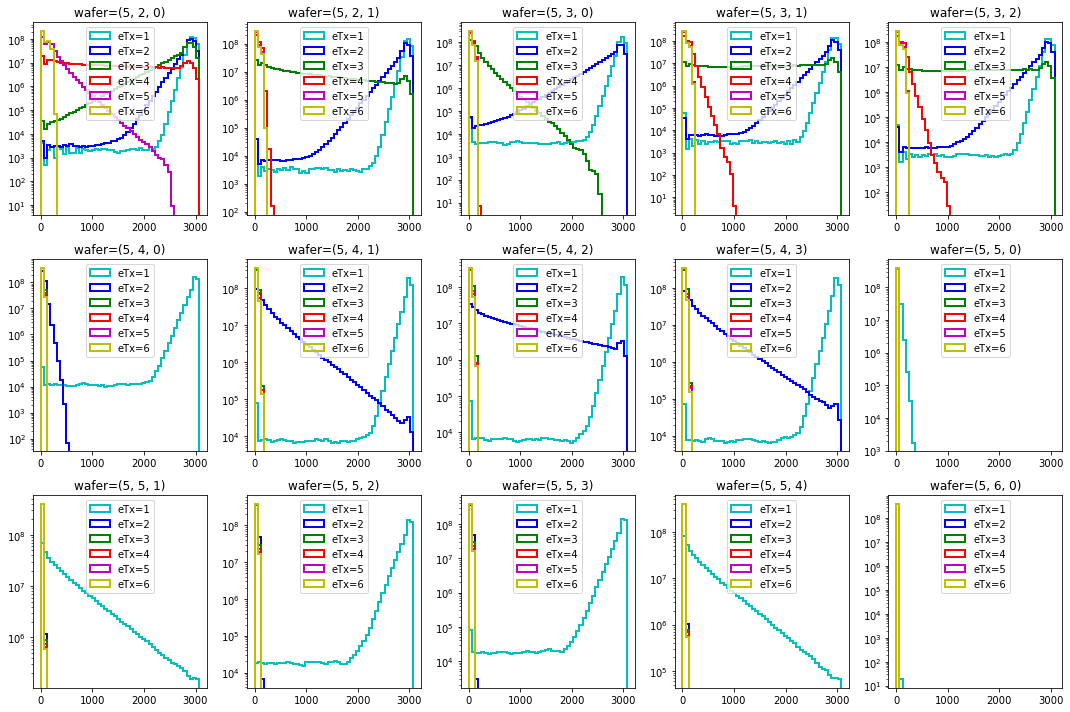

In [7]:
colList = ["c", "b", "g", "r","m","y"]
xArray = []
for i in range(1536*2):
    xArray.append(i)
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
count = 1
plt.subplots(figsize=(15, 10))
#for h in range(len(buffHist)):
for h in range(15):
    #print(count)
    plt.subplot(3, 5, count)
    for eTx in range(len(buffHist)):
        #plt.plot( xArray, buffHist[eTx][h], label="eTx=%i"%(eTx+1))
        plt.hist(xArray, bins=50, weights=buffHist[eTx][h], edgecolor=colList[eTx], label="eTx=%i"%(eTx+1), histtype='step', linewidth=2)
        plt.title("wafer=%s"%str(wedges.index[h]))
        #plt.xlabel("Buffer size (32-bit words)", size=14)
        #plt.xlabel("Buffer size", size=14)
        plt.legend(loc='upper center')
        plt.yscale('log')
    count+=1
plt.show()

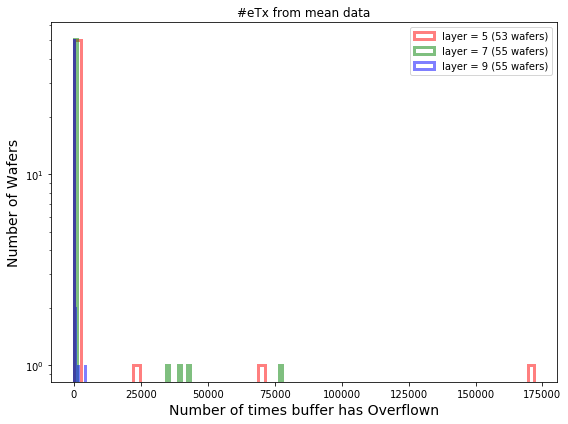

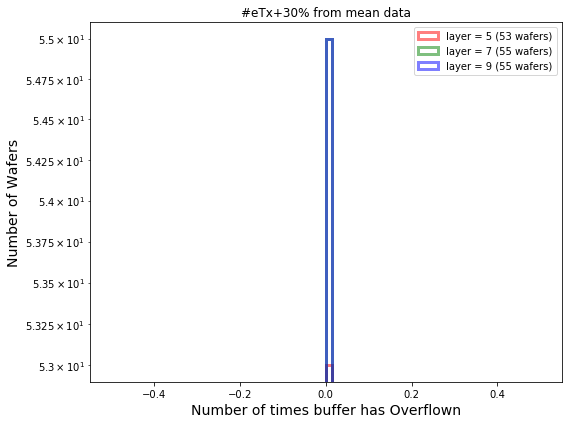

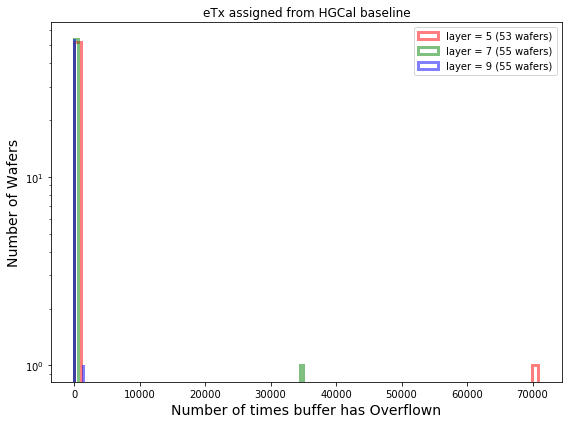

In [8]:
ETx = np.array(fullData.eTx_Mean.tolist())
l1_ETx = ETx[0:53]
l2_ETx = ETx[53:53+55]
l3_ETx = ETx[53+55:53+55+55]
l1_overflow = []
l2_overflow = []
l3_overflow = []
for i in np.arange(len(l1_ETx)):
    eTx = int(l1_ETx[i])
    l1_overflow.append(OF.transpose()[i][eTx-1])

for i in np.arange(len(l2_ETx)):
    eTx = int(l2_ETx[i])
    l2_overflow.append(OF.transpose()[i+53][eTx-1])

for i in np.arange(len(l3_ETx)):
    eTx = int(l3_ETx[i])
    l3_overflow.append(OF.transpose()[i+53+55][eTx-1])
plt.figure(figsize=(8,6))
plt.hist(l1_overflow, bins=70, alpha=0.5, label="layer = 5 (53 wafers)", histtype='step', linewidth=3, edgecolor='r')
plt.hist(l2_overflow, bins=70, alpha=0.5, label="layer = 7 (55 wafers)", histtype='step', linewidth=3, edgecolor='g')
plt.hist(l3_overflow, bins=70, alpha=0.5, label="layer = 9 (55 wafers)", histtype='step', linewidth=3, edgecolor='b')
plt.xlabel("Number of times buffer has Overflown", size=14)
plt.ylabel("Number of Wafers", size=14)
plt.title("#eTx from mean data")
plt.legend(loc="upper right")
plt.yscale('log')


ETx = np.array(fullData.eTx_30percent.tolist())
l1_ETx = ETx[0:53]
l2_ETx = ETx[53:53+55]
l3_ETx = ETx[53+55:53+55+55]
l1_overflow = []
l2_overflow = []
l3_overflow = []
for i in np.arange(len(l1_ETx)):
    eTx = int(l1_ETx[i])
    l1_overflow.append(OF.transpose()[i][eTx-1])

for i in np.arange(len(l2_ETx)):
    eTx = int(l2_ETx[i])
    l2_overflow.append(OF.transpose()[i+53][eTx-1])

for i in np.arange(len(l3_ETx)):
    eTx = int(l3_ETx[i])
    l3_overflow.append(OF.transpose()[i+53+55][eTx-1])
plt.figure(figsize=(8,6))
plt.hist(l1_overflow, bins=70, alpha=0.5, label="layer = 5 (53 wafers)", histtype='step', linewidth=3, edgecolor='r')
plt.hist(l2_overflow, bins=70, alpha=0.5, label="layer = 7 (55 wafers)", histtype='step', linewidth=3, edgecolor='g')
plt.hist(l3_overflow, bins=70, alpha=0.5, label="layer = 9 (55 wafers)", histtype='step', linewidth=3, edgecolor='b')
plt.xlabel("Number of times buffer has Overflown", size=14)
plt.ylabel("Number of Wafers", size=14)
plt.title("#eTx+30% from mean data")
plt.legend(loc="upper right")
plt.yscale('log')



ETx = np.array(fullData.eTx_assigned.tolist())
l1_ETx = ETx[0:53]
l2_ETx = ETx[53:53+55]
l3_ETx = ETx[53+55:53+55+55]
l1_overflow = []
l2_overflow = []
l3_overflow = []
for i in np.arange(len(l1_ETx)):
    eTx = int(l1_ETx[i])
    l1_overflow.append(OF.transpose()[i][eTx-1])

for i in np.arange(len(l2_ETx)):
    eTx = int(l2_ETx[i])
    l2_overflow.append(OF.transpose()[i+53][eTx-1])

for i in np.arange(len(l3_ETx)):
    eTx = int(l3_ETx[i])
    l3_overflow.append(OF.transpose()[i+53+55][eTx-1])
plt.figure(figsize=(8,6))
plt.hist(l1_overflow, bins=70, alpha=0.5, label="layer = 5 (53 wafers)", histtype='step', linewidth=3, edgecolor='r')
plt.hist(l2_overflow, bins=70, alpha=0.5, label="layer = 7 (55 wafers)", histtype='step', linewidth=3, edgecolor='g')
plt.hist(l3_overflow, bins=70, alpha=0.5, label="layer = 9 (55 wafers)", histtype='step', linewidth=3, edgecolor='b')
plt.xlabel("Number of times buffer has Overflown", size=14)
plt.ylabel("Number of Wafers", size=14)
plt.title("eTx assigned from HGCal baseline")
plt.legend(loc="upper right")
plt.yscale('log')

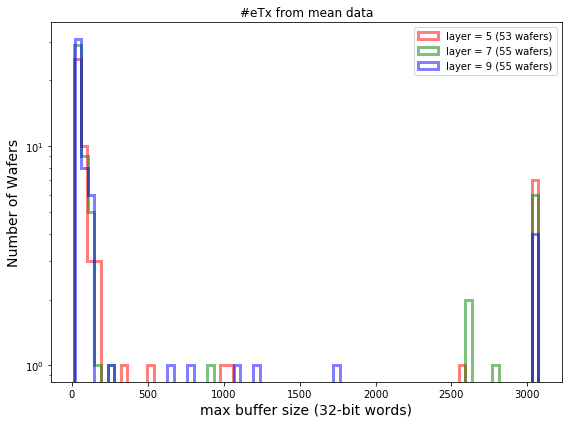

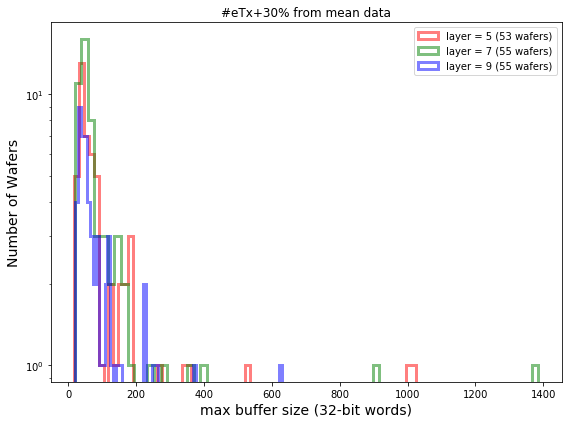

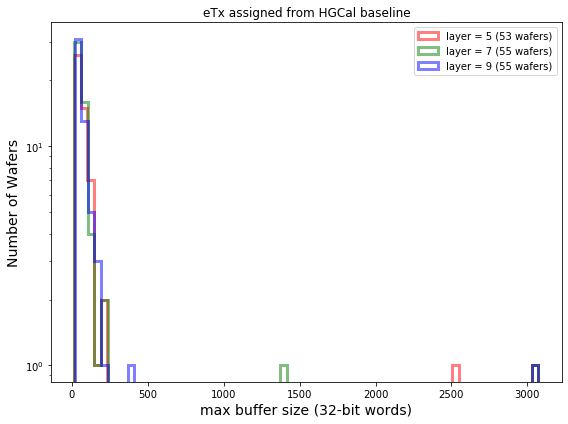

In [9]:
ETx = np.array(fullData.eTx_Mean.tolist())
l1_ETx = ETx[0:53]
l2_ETx = ETx[53:53+55]
l3_ETx = ETx[53+55:53+55+55]
l1_overflow = []
l2_overflow = []
l3_overflow = []
for i in np.arange(len(l1_ETx)):
    eTx = int(l1_ETx[i])
    l1_overflow.append(MS.transpose()[i][eTx-1])

for i in np.arange(len(l2_ETx)):
    eTx = int(l2_ETx[i])
    l2_overflow.append(MS.transpose()[i+53][eTx-1])

for i in np.arange(len(l3_ETx)):
    eTx = int(l3_ETx[i])
    l3_overflow.append(MS.transpose()[i+53+55][eTx-1])
plt.figure(figsize=(8,6))
plt.hist(l1_overflow, bins=70, alpha=0.5, label="layer = 5 (53 wafers)", histtype='step', linewidth=3, edgecolor='r')
plt.hist(l2_overflow, bins=70, alpha=0.5, label="layer = 7 (55 wafers)", histtype='step', linewidth=3, edgecolor='g')
plt.hist(l3_overflow, bins=70, alpha=0.5, label="layer = 9 (55 wafers)", histtype='step', linewidth=3, edgecolor='b')
plt.xlabel("max buffer size (32-bit words)", size=14)
plt.ylabel("Number of Wafers", size=14)
plt.title("#eTx from mean data")
plt.legend(loc="upper right")
plt.yscale('log')


ETx = np.array(fullData.eTx_30percent.tolist())
l1_ETx = ETx[0:53]
l2_ETx = ETx[53:53+55]
l3_ETx = ETx[53+55:53+55+55]
l1_overflow = []
l2_overflow = []
l3_overflow = []
for i in np.arange(len(l1_ETx)):
    eTx = int(l1_ETx[i])
    l1_overflow.append(MS.transpose()[i][eTx-1])

for i in np.arange(len(l2_ETx)):
    eTx = int(l2_ETx[i])
    l2_overflow.append(MS.transpose()[i+53][eTx-1])

for i in np.arange(len(l3_ETx)):
    eTx = int(l3_ETx[i])
    l3_overflow.append(MS.transpose()[i+53+55][eTx-1])
plt.figure(figsize=(8,6))
plt.hist(l1_overflow, bins=70, alpha=0.5, label="layer = 5 (53 wafers)", histtype='step', linewidth=3, edgecolor='r')
plt.hist(l2_overflow, bins=70, alpha=0.5, label="layer = 7 (55 wafers)", histtype='step', linewidth=3, edgecolor='g')
plt.hist(l3_overflow, bins=70, alpha=0.5, label="layer = 9 (55 wafers)", histtype='step', linewidth=3, edgecolor='b')
plt.xlabel("max buffer size (32-bit words)", size=14)
plt.ylabel("Number of Wafers", size=14)
plt.title("#eTx+30% from mean data")
plt.legend(loc="upper right")
plt.yscale('log')



ETx = np.array(fullData.eTx_assigned.tolist())
l1_ETx = ETx[0:53]
l2_ETx = ETx[53:53+55]
l3_ETx = ETx[53+55:53+55+55]
l1_overflow = []
l2_overflow = []
l3_overflow = []
for i in np.arange(len(l1_ETx)):
    eTx = int(l1_ETx[i])
    l1_overflow.append(MS.transpose()[i][eTx-1])

for i in np.arange(len(l2_ETx)):
    eTx = int(l2_ETx[i])
    l2_overflow.append(MS.transpose()[i+53][eTx-1])

for i in np.arange(len(l3_ETx)):
    eTx = int(l3_ETx[i])
    l3_overflow.append(MS.transpose()[i+53+55][eTx-1])
plt.figure(figsize=(8,6))
plt.hist(l1_overflow, bins=70, alpha=0.5, label="layer = 5 (53 wafers)", histtype='step', linewidth=3, edgecolor='r')
plt.hist(l2_overflow, bins=70, alpha=0.5, label="layer = 7 (55 wafers)", histtype='step', linewidth=3, edgecolor='g')
plt.hist(l3_overflow, bins=70, alpha=0.5, label="layer = 9 (55 wafers)", histtype='step', linewidth=3, edgecolor='b')
plt.xlabel("max buffer size (32-bit words)", size=14)
plt.ylabel("Number of Wafers", size=14)
plt.title("eTx assigned from HGCal baseline")
plt.legend(loc="upper right")
plt.yscale('log')


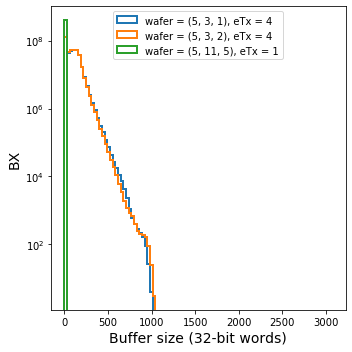

In [10]:
l1_eTx = [4, 4, 1]
l1_wafer = [3, 4, 51]
l1_eTx_wafer = [[4, 3],[4, 4], [1, 51]]
#l1_eTx_wafer = [[1,51]]

xArray = []
for i in range(1536*2):
    xArray.append(i)
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
#count = 1
plt.subplots(figsize=(5, 5))
#for h in range(len(buffHist)):
for (eTx, h) in l1_eTx_wafer:
    #print(eTx,h)
    #plt.plot( xArray, buffHist[eTx][h], label="eTx=%i"%(eTx+1))
    lab = "wafer = %s, eTx = %i"%(str(wedges.index[h]), eTx)
    #lab = "eTx = %s, wafer = %i"%(eTx,h)
    plt.hist(xArray, bins=100, weights=buffHist[eTx-1][h], label=lab, histtype='step', linewidth=2)
    #plt.plot(xArray, buffHist[eTx-1][h])
    #plt.title("wafer=%s"%str(wedges.index[h]))
    plt.xlabel("Buffer size (32-bit words)", size=14)
    plt.ylabel("BX", size=14)
    #plt.xlabel("Buffer size", size=14)
    plt.legend(loc='upper center')
    plt.yscale('log')
    #count+=1
plt.show()

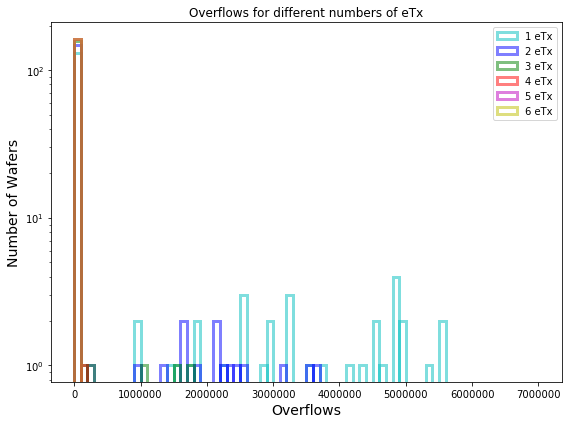

In [11]:
plt.figure(figsize=(8,6))
plt.hist(OF[0], bins=70, alpha=0.5, label="1 eTx", fill=False, linewidth=3, edgecolor='c',range=[0.0, 0.7e7])
plt.hist(OF[1], bins=70, alpha=0.5, label="2 eTx", fill=False, linewidth=3, edgecolor='b',range=[0.0, 0.7e7])
plt.hist(OF[2], bins=70, alpha=0.5, label="3 eTx", fill=False, linewidth=3, edgecolor='g',range=[0.0, 0.7e7])
plt.hist(OF[3], bins=70, alpha=0.5, label="4 eTx", fill=False, linewidth=3, edgecolor='r',range=[0.0, 0.7e7])
plt.hist(OF[4], bins=70, alpha=0.5, label="5 eTx", fill=False, linewidth=3, edgecolor='m',range=[0.0, 0.7e7])
plt.hist(OF[5], bins=70, alpha=0.5, label="6 eTx", fill=False, linewidth=3, edgecolor='y',range=[0.0, 0.7e7])
plt.xlabel("Overflows", size=14)
plt.ylabel("Number of Wafers", size=14)
plt.yscale('log')
plt.title("Overflows for different numbers of eTx")
plt.legend(loc='upper right')

In [12]:
#dictionaly of the labels for different types of plots
Labels ={'occ':{'Title':'Layer %i',
                'colorLabel':'Average cell occupancy above zero suppression',
                'nDec':1,
                'zMax':260},
         'TotalWords':{'Title':'Layer %i',
                      'colorLabel':'Average data size (32b words) after L1A',
                      'nDec':1,
                      'zMax':200},
         'EmptyLinks':{'Title':'Layer %i',
                      'colorLabel':'Average # of empty eRx packets',
                      'nDec':1,
                      'zMax':6},
         'min_eTx':{'Title':'Layer %i',
                      'colorLabel':'Minimum number of eTx with 0 overflows',
                      'nDec':0,
                      'zMax':6},
         'maxSize':{'Title':'Layer %i',
                      'colorLabel':'Max buffer size (32b words), with 0 overflows',
                      'nDec':0,
                      'zMax':3300},
         'eTx_Mean':{'Title':'Layer %i',
                      'colorLabel':'#eTx from mean data',
                      'nDec':2,
                      'zMax':6},
         'eTx_30percent':{'Title':'Layer %i',
                      'colorLabel':'#eTx+30% from mean data',
                      'nDec':0,
                      'zMax':6},
         'eTx_assigned':{'Title':'Layer %i',
                      'colorLabel':'#eTx assigned from HGCal baseline',
                      'nDec':0,
                      'zMax':6},
         'maxSize_Mean':{'Title':'Layer %i',
                      'colorLabel':'Max buffer size for #eTx from mean data',
                      'nDec':0,
                      'zMax':3300},
         'maxSize_30percent':{'Title':'Layer %i',
                      'colorLabel':'Max buffer size for #eTx+30% from mean data',
                      'nDec':0,
                      'zMax':3300},
         'maxSize_assigned':{'Title':'Layer %i',
                      'colorLabel':'Max buffer size for #eTx assigned from HGCal baseline',
                      'nDec':0,
                      'zMax':3300},
         'overflows_Mean':{'Title':'Layer %i',
                      'colorLabel':'Overflow counter for #eTx from mean data',
                      'nDec':0,
                      'zMax':40000},
         'overflows_30percent':{'Title':'Layer %i',
                      'colorLabel':'Overflow counter for #eTx+30% from mean data',
                      'nDec':0,
                      'zMax':40000},
         'overflows_assigned':{'Title':'Layer %i',
                      'colorLabel':'Overflow counter for #eTx assigned from HGCal baseline',
                      'nDec':0,
                      'zMax':40000},
        }

occ


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


TotalWords
EmptyLinks
min_eTx
maxSize
eTx_Mean
eTx_30percent
eTx_assigned
maxSize_Mean
maxSize_30percent
maxSize_assigned
overflows_Mean
overflows_30percent
overflows_assigned


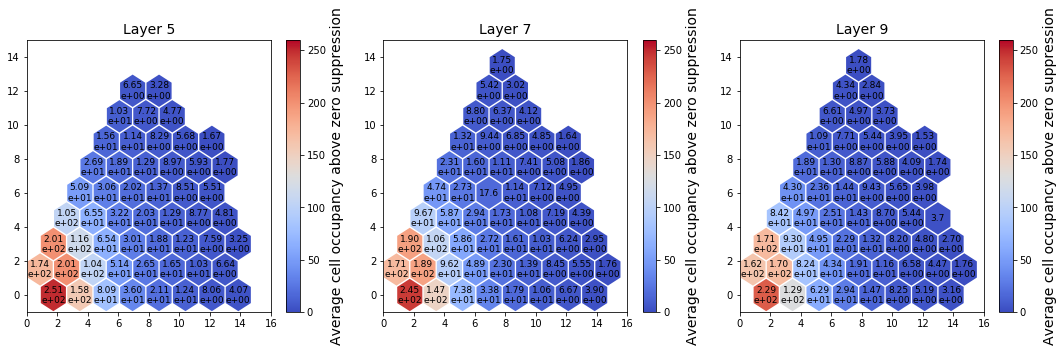

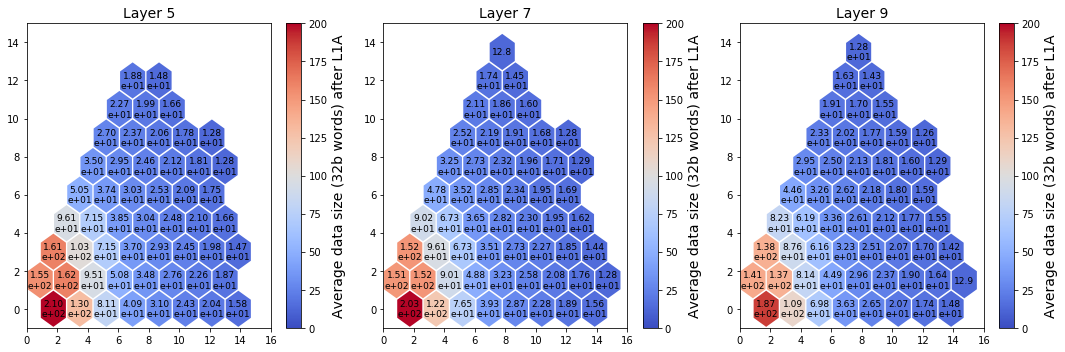

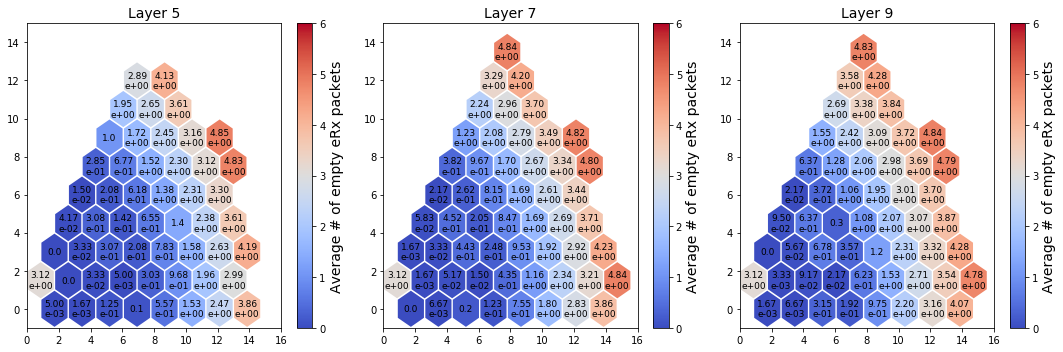

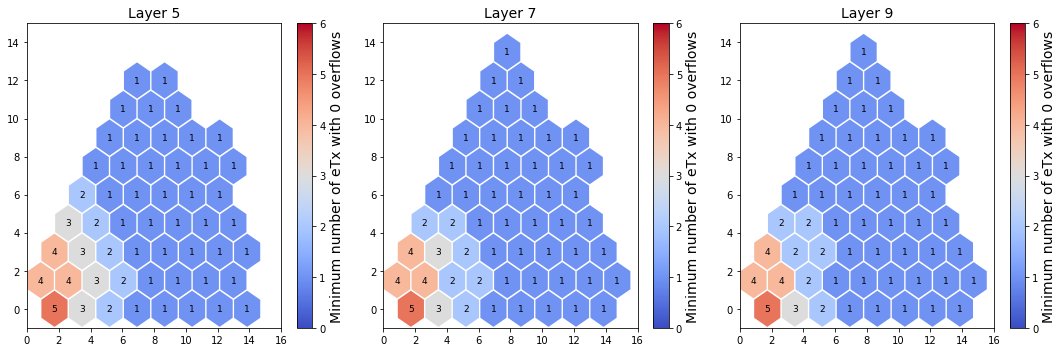

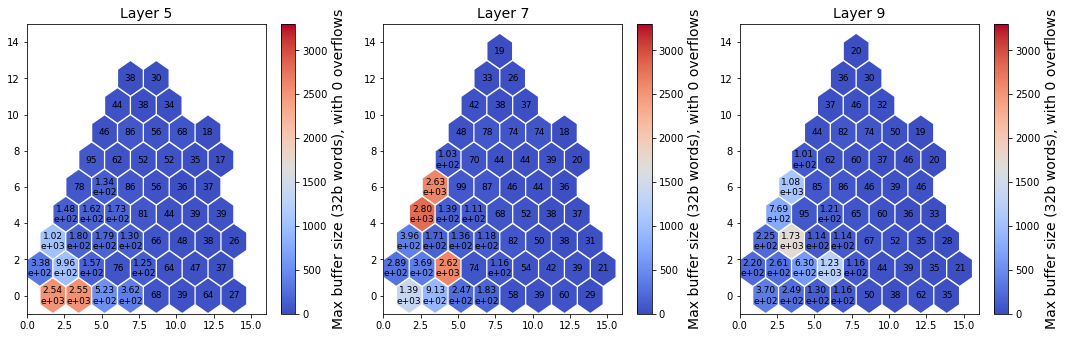

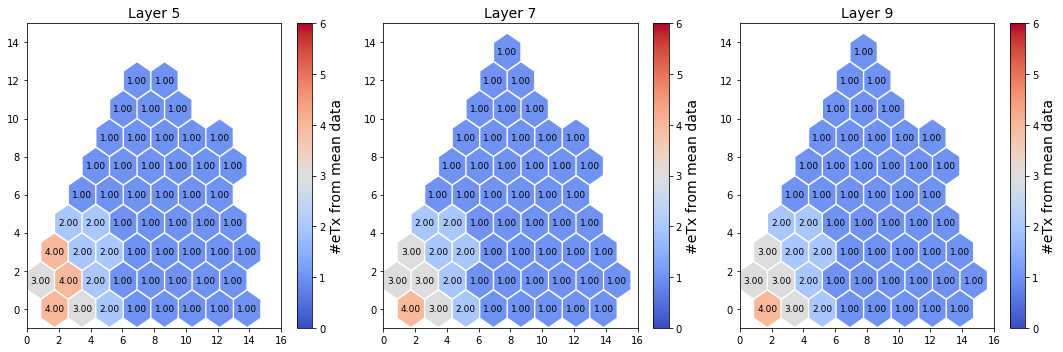

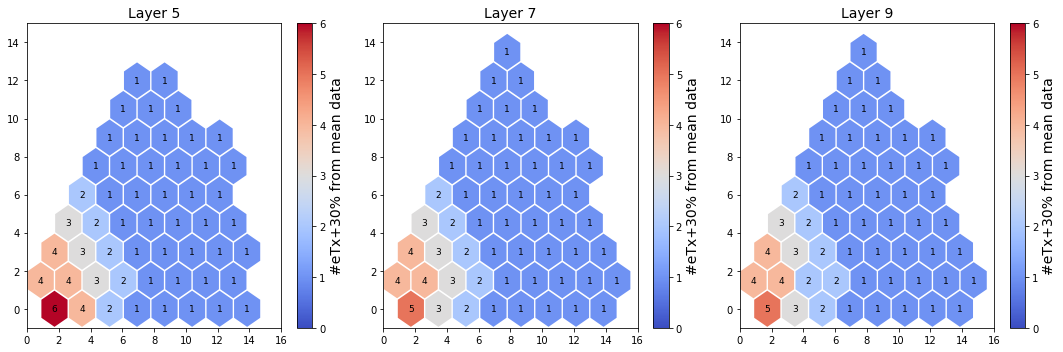

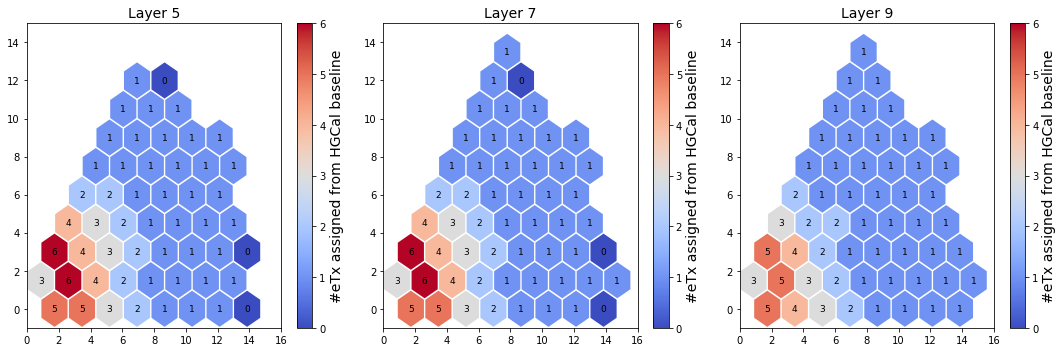

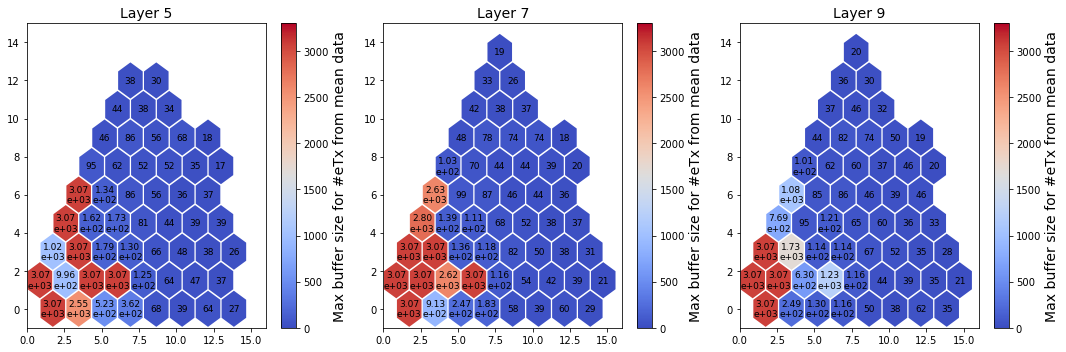

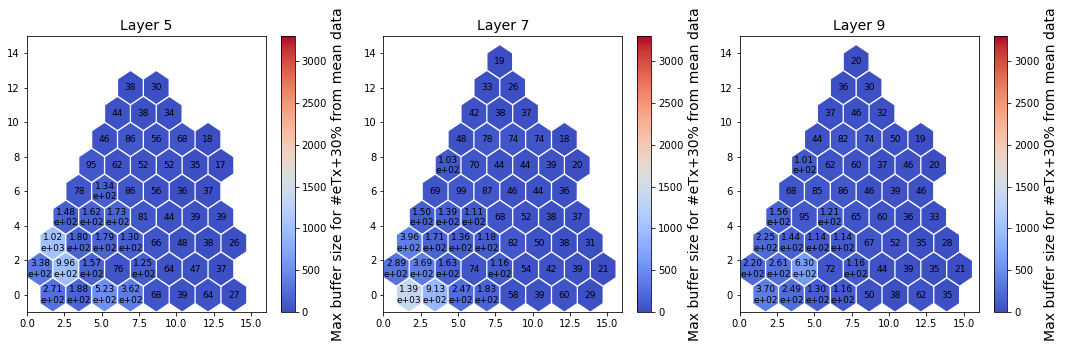

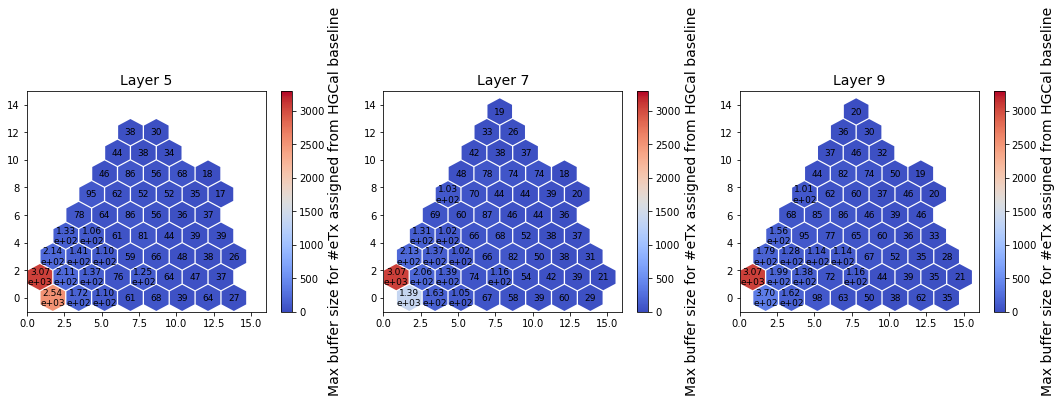

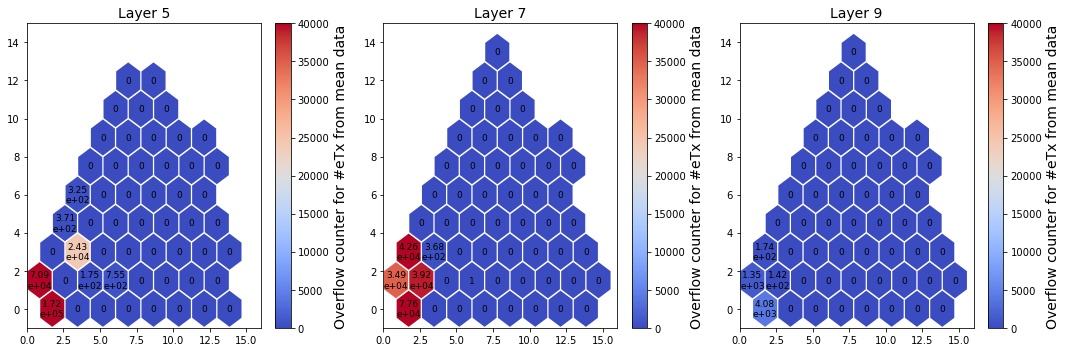

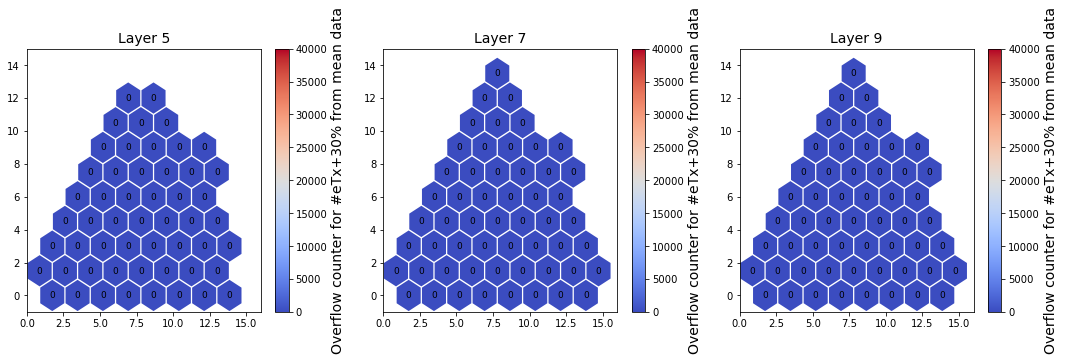

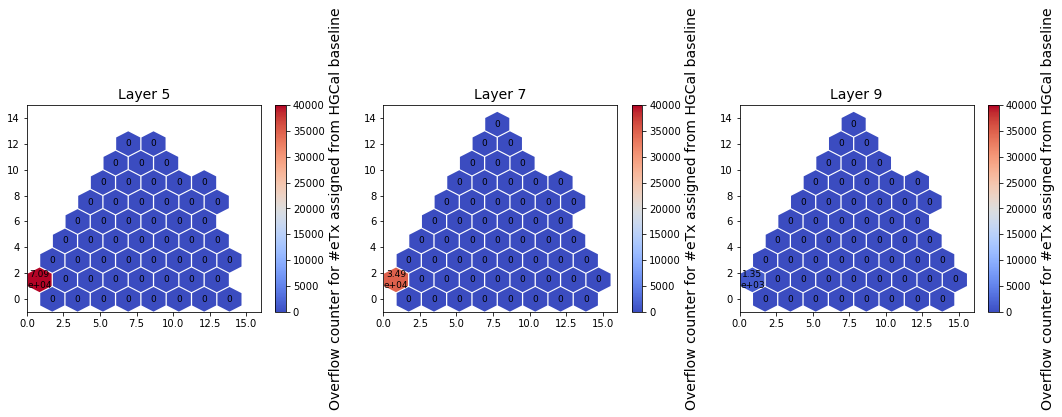

In [13]:
for var in Labels:
    print(var)
    plt.subplots(figsize=(15, 5))
    count=1
    for layer in [5,7,9]:
        wedge = wedges.loc[layer]
        #fig, ax = plt.subplots()
        plt.subplot(1, 3, count)
        ax=plt.gca()
        patches = []
        for w in wedge.index:
            patches.append(mpatches.RegularPolygon((wedge.loc[w].x,wedge.loc[w].y),6, .95))
        df = fullData
        extra = "ttbar"
        data = df.loc[layer,var].values.flatten()
        waferCollection = PatchCollection(patches,cmap=matplotlib.cm.coolwarm)
        waferCollection.set_array(data)
        waferCollection.set_clim([0,Labels[var]['zMax']])
        ax.add_collection(waferCollection)
        plt.axis([0,16,-1,15])
        plt.rcParams["figure.autolayout"] = True
        # ax.set_xticklabels([])
        # ax.set_yticklabels([]);
        cbar = plt.colorbar(waferCollection)
        cbar.set_label(Labels[var]['colorLabel'],fontsize=14)

        wedge['data'] = data
        plt.title(Labels[var]['Title']%layer,fontsize=14)
        for x,y,d in wedge[['x','y','data']].values:
        #     s = data[i]
            text = f'%.{Labels[var]["nDec"]}f'%d
            if len(str(d))>4:
                text = "{:.2e}".format(d)
                text = "%s\ne%s"%(text.split("e")[0], text.split("e")[1])
            plt.text(x,y,text,fontsize=9,horizontalalignment='center',verticalalignment='center')         

        #fig.savefig(f'Plots/{var}_layer{layer}{extra}.png')
        count+=1
plt.show()

